In [1]:
%matplotlib inline
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose, Lambda
import matplotlib.pyplot as plt
from utils import dkl
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.manual_seed(1337) 

Na początku załadujmy ponownie MNIST.

In [2]:
batch_size = 100
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

train_data = MNIST(root='./data/', 
                   train=True, 
                   transform=transforms,    
                   download=True)

test_data = MNIST(root='./data/', 
                   train=False, 
                   transform=transforms,    
                   download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# Autoenkodery, a modele generatywne

Zadaniem autoenkoderów w wersji podstawowej jest jak najlepsze odtwarzanie wejścia(zwrócona rekonstrukcja powinna być jak najbardziej podobna do wejścia). Dane w przestrzeni ukrytej nie mają określonej struktury (rozkładu), którą można wykorzystać do generowania nowych przykładów.

W tym celu model powinien być w stanie nauczyć się nieznanego rozkładu danych $P_X$ oraz mieć możliwość generowania nowych przykładów należących do rozkładu $P_X$ z rozkładu $P_Z$ w przestrzeni ukrytej (np. zadanego z góry rozkładu takiego jak $\mathcal{N}(0, \mathbb{I})$).

Można w tym celu wykorzystać np. dywergencję Kullbacka-Leiblera:

## Kullback-Leibler
Dywergencja Kullbacka-Leiblera oznaczana przez $D_{KL}(p\mid\mid q)$, gdzie $p$ oraz $q$ są rozkładami prawdopodobieństwa jest zadana wzorem:

$$\begin{align*}
D_{KL}(p\mid\mid q)&=-\sum\limits_{x} p(x)\log{q(x)} + \sum\limits_{x} p(x)\log{p(x)} \\
& = \sum\limits_{x} p(x) (\log(p(x) - \log(q(x)))) \\
& = \sum\limits_{x} p(x) \log\frac{p(x)}{q(x)}
\end{align*}$$

Jest to miara zadająca podobieństwo dwóch podanych rozkładów. Nie zadaje ona jednak odległości takiej jak metryka, ponieważ $D_{KL}$ nie spełnia warunku symetrii.   

# Variational Autoencoder (VAE)
Oznaczenia dla $X, Z$ są takie same jak w notebook'u encoder-01.ipynb.
Model ten podobnie jak autoenkoder w wersji podstawowej składa się z dwóch części:
  * enkodera $E: X\rightarrow Z$
  * dekodera $D: Z\rightarrow X$

W tym wypadku dekoder pełni jednak dodatkową funkcję generatora.
Wspomniana przed chwilą miara może być wykorzystana do narzucenia rozkładu $p(z)$.
Osiągnięte to będzie poprzez __maksymalizowanie__ następującej funkcji (dokładne rachunki można znaleźć np. w [1, 2]):

$$L=\mathbb{E}_{q(z\mid x)}\log p(x\mid z)-D_{KL}(q(z\mid x)\mid\mid p(z))$$

W naszym przypadku rozkład $p(z)$ (prior) jest narzucony np. jako $\mathcal{N}(0,\mathbb{I})$ i reprezentuje rozkład w przestrzeni ukrytej. Rozkład $q(z\mid x)$ jest rozkładem realizowanym przez enkoder, a jego celem jest jak najlepsze przybliżanie rozkładu $p(z\mid x)$ (posterior). W naszym przypadku rozkład ten będzie postaci $\mathcal{N} (\mu, \Sigma)$. $p(x\mid z)$ jest natomiast rozkładem realizowanym przez dekoder, we wzorze tym $z$ nie jest tak na prawdę dowolne, bo zależy od $x$.

Pierwszy człon może być obliczony za pomocą entropii krzyżowej, a druga przy założeniu $p(z) = \mathcal{N} (0, \mathbb{I})$ oraz $q(z\mid x) = \mathcal{N} (\mu, \Sigma)$

$$ D_{KL}[N(\mu, \Sigma) || N(0, \mathbb{I})] = -\frac{1}{2} \sum (-\Sigma - \mu^2 + 1 + \log\Sigma)$$


Wzór ten jest już zaimplementowany w pliku utils.py
(__UWAGA__ 1. zamiast wariancji we wzorze używany jest logarytm wariancji, robione jest to w taki sposób między innymi ze względu na stabilność uczenia oraz fakt że wymusza to dodatniość wariancji).
(__UWAGA__ 2. nomenklatura $\textit{prior} - \textit{posterior}$ wywodzi się z wnioskowania Bayesowskiego: https://en.wikipedia.org/wiki/Bayesian_inference).

In [3]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, intermediate_dims):       
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        encoder_list = []
        in_dim = input_dim
        for out_dim in intermediate_dims:
            encoder_list.append(torch.nn.Linear(in_dim, out_dim))
            encoder_list.append(torch.nn.ReLU())
            in_dim = out_dim
        self.encoder = torch.nn.Sequential(*encoder_list)

        self.mu_layer = torch.nn.Linear(in_dim, latent_dim)
        self.logvar_layer = torch.nn.Linear(in_dim, latent_dim) # diagonalna macierz kowariancji

        decoder_list = []
        in_dim = latent_dim
        for out_dim in reversed(intermediate_dims):
            decoder_list.append(torch.nn.Linear(in_dim, out_dim))
            decoder_list.append(torch.nn.ReLU())
            in_dim = out_dim
        decoder_list.append(torch.nn.Linear(in_dim, input_dim))
        decoder_list.append(torch.nn.Sigmoid())
        self.decoder = torch.nn.Sequential(*decoder_list)
        
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def decode(self, z):
        return self.decoder(z)
    
    def encode(self, x):
        enc = self.encoder(x)
        return self.mu_layer(enc), self.logvar_layer(enc)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decode(z)
        return mu, logvar, decoded

In [4]:
def loss_fn(x, x_decoded, mu, logvar, beta=1.0):
    BCE = torch.nn.functional.binary_cross_entropy(x_decoded, x, reduction='sum')
    DKL = dkl(mu, logvar)
    return BCE + beta * DKL

def train_loop(model, epochs, lr, beta=1.0):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for step, (x, _) in enumerate(train_loader):
            x = x.to(device)
            mu, logvar, x_decoded = model(x)

            opt.zero_grad()
            loss = loss_fn(x, x_decoded, mu, logvar, beta)
            loss.backward()
            opt.step()
            overall_loss += loss.item()
        print("\tEpoch", epoch + 1, "\tLoss: ", overall_loss / (step * batch_size))

In [5]:
epochs = 20
lr = 1e-3
intermediate_dims = [512, 256]
latent_dim = 20
input_dim = 28 * 28

model = VAE(input_dim, latent_dim, intermediate_dims).to(device)

train_loop(model, epochs, lr)

	Epoch 1 	Loss:  168.81988778498018
	Epoch 2 	Loss:  125.08238491561457
	Epoch 3 	Loss:  115.52757101679883
	Epoch 4 	Loss:  111.49027144850793
	Epoch 5 	Loss:  108.82606795831595
	Epoch 6 	Loss:  107.08486158571577
	Epoch 7 	Loss:  105.81402324186143
	Epoch 8 	Loss:  104.84310145815944
	Epoch 9 	Loss:  104.02380962085246
	Epoch 10 	Loss:  103.35241704924874
	Epoch 11 	Loss:  102.78849213206907
	Epoch 12 	Loss:  102.28401241652755
	Epoch 13 	Loss:  101.94872360509704
	Epoch 14 	Loss:  101.55087853127608
	Epoch 15 	Loss:  101.21747337685204
	Epoch 16 	Loss:  100.93655790249375
	Epoch 17 	Loss:  100.6487035521442
	Epoch 18 	Loss:  100.43309888225167
	Epoch 19 	Loss:  100.17848446955864
	Epoch 20 	Loss:  99.98180941217133


Zobaczmy jak wyglądają wygenerowane przykłady. Poniższy przykład polega na wylosowaniu 20 punktów w przestrzeni ukrytej (z rozkładu $\mathcal{N}(0,\mathbb{I})$ który próbowalismy narzucić w trakcie treningu). Następnie punkty te są zamieniane na obrazki poprzez nauczony dekoder. Wszystkie narysowane obrazki, przedstawiają wygenerowane w ten sposób przykłady.

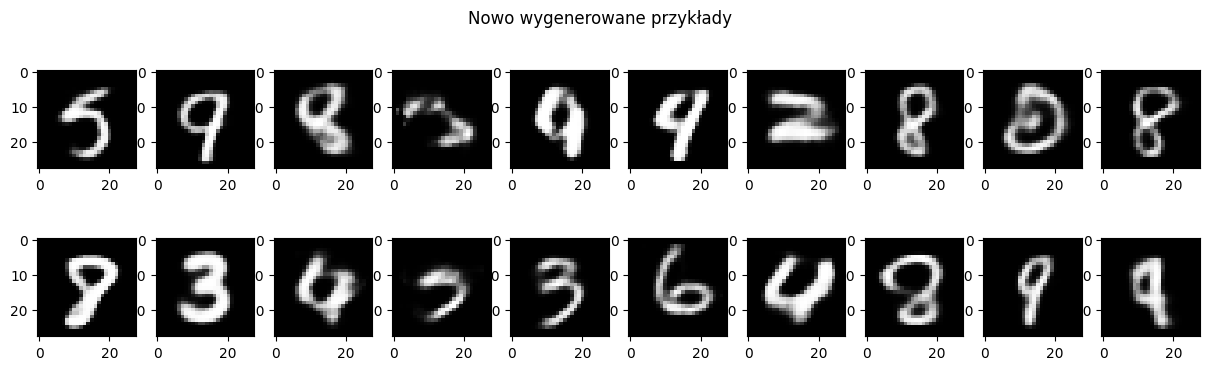

In [6]:
model.eval()
with torch.no_grad():
    sampled_z = torch.randn(20, model.latent_dim).to(device)
    generated = model.decode(sampled_z)

    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    plt.suptitle("Nowo wygenerowane przykłady")
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.show()

# ZADANIE 2 (Wymagane)
Wytrenuj modele z klas: AutoEncoder oraz VAE (AutoEncoder w poprzednim notebooku) na ustalonym zbiorze danych z MNIST. Dokonaj wizualizacji procesu i efektów uczenia. Porównaj opisowo otrzymane wyniki. Dodatkowo odpowiedz na następujące pytania:
1. Przy preprocessingu danych z MNIST nie korzystaliśmy ze StandardScaller. Dlaczego? Czy wykorzystanie tej operacji w tym przypadku jest uzasadnione/ słuszne?
2. Na końcu enkodera z klasy Autoencoder wstawiliśmy Sigmoidę. Dlaczego? Jakie korzyści płyną z takiego rozwiązania?

In [7]:
# odpowiedz na pytania

In [8]:
# kod do zadania

# Hipoteza rozmaitości [3]
Hipoteza rozmaitości, mówi o tym że wysoko wymiarowe dane znajdują się tak na prawdę na nisko wymiarowych rozmaitościach zanurzonych w wysoko wymiarowej przetrzeni danych.

W notebookach (np. w nazwach zmiennych) przewijało się sformuowanie 'latent'. Przestrzeń ukryta (latent feature space) to właśnie rozmaitość o której mowa w hipotezie rozmaitości. W idealnym modelu (albo po prostu dość dobrze oddającym reprezentację) zakładamy, że dla punktów $x$, $y$ w faktycznej przestrzeni danych, punkty $x'$ = $E(x)$ , $y'$ = $E(y)$ (enkodowane) w przestrzeni kodów też są blisko siebie  

# Zadanie 3 (Wymagane)

W przestrzeniu ukrytej dla dwóch punktów $z_1$, $z_2$ oraz wytrenowanego modelu AutoEnkodera/VAE, sprawdź zachowanie wygenerowanych obrazów pomiędzy nimi (np. na odcinku łączącym te dwa punkty). Jakich wyników można się spodziewać? Czy otrzymane obrazy są zgodne z przewidywaniami? Czy występują różnice pomiędzy AutoEnkoderem, a VAE?

In [ ]:
# odpowiedz

In [ ]:
# kod do zadania

Poniżej przedstawiony jest kawałek rozmaitości dla modelu o przestrzeni ukrytej wymiaru 2

In [9]:
epochs = 20
lr = 1e-3
intermediate_dims = [512, 256, 64]
latent_dim = 2
input_dim = 28 * 28

model = VAE(input_dim, latent_dim, intermediate_dims).to(device)

train_loop(model, epochs, lr)

	Epoch 1 	Loss:  188.40765809226315
	Epoch 2 	Loss:  159.529332350793
	Epoch 3 	Loss:  153.30098975179988
	Epoch 4 	Loss:  149.5626578966246
	Epoch 5 	Loss:  146.93320465750207
	Epoch 6 	Loss:  145.43117344010852
	Epoch 7 	Loss:  144.10799715019826
	Epoch 8 	Loss:  142.94907461328776
	Epoch 9 	Loss:  142.05938613509494
	Epoch 10 	Loss:  141.4713250273894
	Epoch 11 	Loss:  141.0814953307596
	Epoch 12 	Loss:  140.44738801322518
	Epoch 13 	Loss:  140.07464211185308
	Epoch 14 	Loss:  139.54653648007096
	Epoch 15 	Loss:  139.41740743035268
	Epoch 16 	Loss:  139.06608784823663
	Epoch 17 	Loss:  138.99157850975584
	Epoch 18 	Loss:  138.87057061247913
	Epoch 19 	Loss:  139.23662319686457
	Epoch 20 	Loss:  138.6070668399155


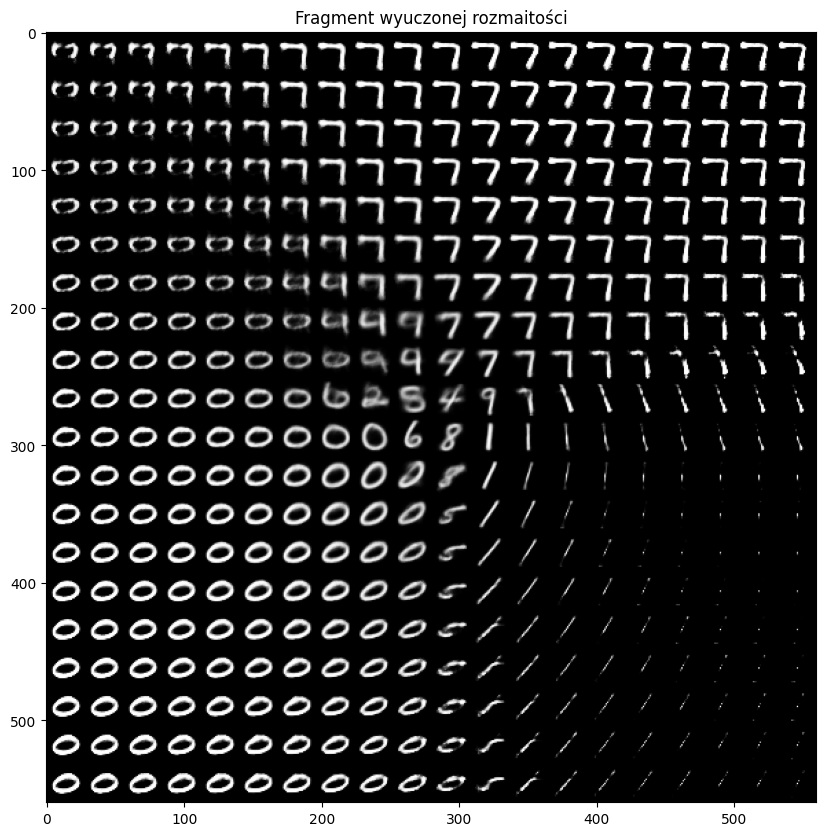

In [10]:
model.eval()
n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = torch.linspace(-10,10,n)
grid_y = torch.linspace(-10,10,n)
with torch.no_grad():
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = torch.tensor([xi, yi], device=device).reshape((1, 2))
            x_decoded = model.decoder(z_sample)
            digit = x_decoded.reshape(digit_size, digit_size).cpu()
            figure[(n-1-i) * digit_size: (n-i) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.title("Fragment wyuczonej rozmaitości")
    plt.imshow(figure, origin='upper', cmap='gray')
    plt.show()


Referencje:

[1] https://lilianweng.github.io/posts/2018-08-12-vae/

[2] https://arxiv.org/pdf/1312.6114.pdf

[3] https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis